# Surface Mining Screening

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2), 
[s2_12a](https://explorer.digitalearth.africa/s2_12a),
[WOFS](https://explorer.digitalearth.africa/products/ls_usgs_wofs_scene/extents)

## Background

[Surface mining](https://americanmineservices.com/types-of-surface-mining) refers to the removal of the terrain surface to access minerals underneath. In particular, surface mining is used to retrieve sand, gravel, stones, coal, iron and other metals. Surface mining is often more cost-effective than gouging tunnels and subterranean shafts to access minerals underground.

Although surface mining contributes to the source of income for a country, these operations can result in deleterious impacts on farmlands, forests, and water bodies. Government officials are making efforts to identify areas of these mining activities. 

This notebook demonstrates a method for identifying areas where there is surface mining activities. The notebook combined with methods based on vegetation loss and water detection. Although the notebook aids in detecting these areas further verification by government agencies or institutions are required to validate the operations on the ground.

## Description

Surface mining operations often result in the clearing of vegetation and the develpoment of water from the land. Using remote sensing images Sentinel-2 and DE Africa's Water Observations from Space (WOfS) product, this notebook screen areas where there is a possibility of surface mining. 

The notebook uses Normalised Difference Vegetation Index from Rouse 1973 (NDVI) to determine vegetation loss, where loss occurs if the change in NDVI is negative. DE Africa's Water Observations from Space (WOfS) product is used to identify water.

The final product identifies pixels that exhibit vegetation loss, and the presence of water.
In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

The notebook demonstrates how to:

1. Load data for a given location and time period
2. Calculate the vegetation change using NDVI
3. Calculate the presence of water
4. Combine vegetation change and water extent change into one plot to show possible mining areas

***

## Getting started

### Load packages

In [1]:
import sys
import datacube

# Import DE Africa functions
sys.path.append('../Scripts')
from deafrica_dask import create_local_dask_cluster

# Import functions for this notebook
from Land_degradation_functions import calculate_area_per_pixel, load_vector_file, process_data, calculate_vegetation_loss, plot_possible_mining, plot_vegetationloss_mining 

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app='surface_mining')

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:39147 Dashboard: /user/caitlinadams/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The area of interest must be defined with a shapefile (`.shp`) or a KML file (`.kml`).

The parameters are:

* `start_year`: The year to start the analysis
* `end_year`: The year to end the analysis
* `vector_file`: The file path and name of a vector file containing the extent. Can be a `.kml` file, or a `.shp` file.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of the Essen Apam Forest Reserve, Ghana, and uses the shapefile provided in **Supplementary Data**.

In [4]:
start_year = 2017
end_year = 2021

vector_file = "../Supplementary_data/Land_degradation/Apam_forest.shp"

### View the area of interest defined by the vector file

In [5]:
gdf, geom = load_vector_file(vector_file)

Label(value='')

Map(center=[6.328635468846285, -1.8708615021743045], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Load and process data

This analysis uses two datasets:

* Sentinel-2 for identifying vegetation loss
* Water Observations from Space (WOfS) for identifying water

If an area has experienced both vegetation loss and water presence, it may be related to surface mining activty. 

The function below loads Sentinel-2 and WOfS for the area of interest and does a number of cleaning and processing steps. The outcomes are:

* `sentinel_2` - an annual geomedian of the Sentinel-2 bands and NDVI
* `wofs` - the total number of years water was observered

The function will also plot the geomedian for the start, middle, and end of the time range.

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Re-scaling Sentinel-2 data
Returning 276 time steps as a dask array
Rasterizing to match xarray.DataArray dimensions (848, 836)


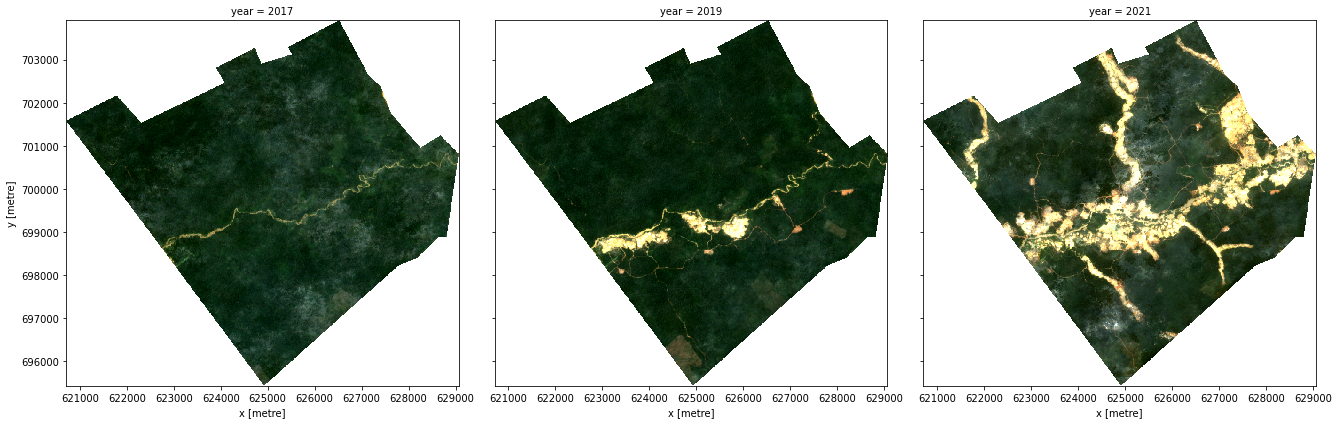

In [6]:
sentinel_2, wofs = process_data(dc, gdf, geom, start_year, end_year)

## Calculate vegetation loss

The next function determines whether NDVI decreased between one year and the next. If so, the area experienced vegetation loss. 

The function returns the annual vegetation loss (in square kilometres) and the total vegetation loss over all years of the analysis. It then plots the annual vegetation loss.

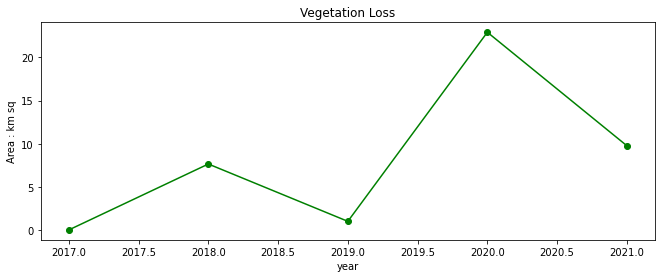

In [7]:
veg_loss_annual, veg_loss_all = calculate_vegetation_loss(sentinel_2)

## Determine possible mining areas

When water (WOFS) and vegetation loss are coincident, the area is classified as high-potential mining site.

Areas within 250 metres of a high-potential mining site where there was only vegetation loss are considered to be possible mining sites.

Rasterizing to match xarray.DataArray dimensions (848, 836)


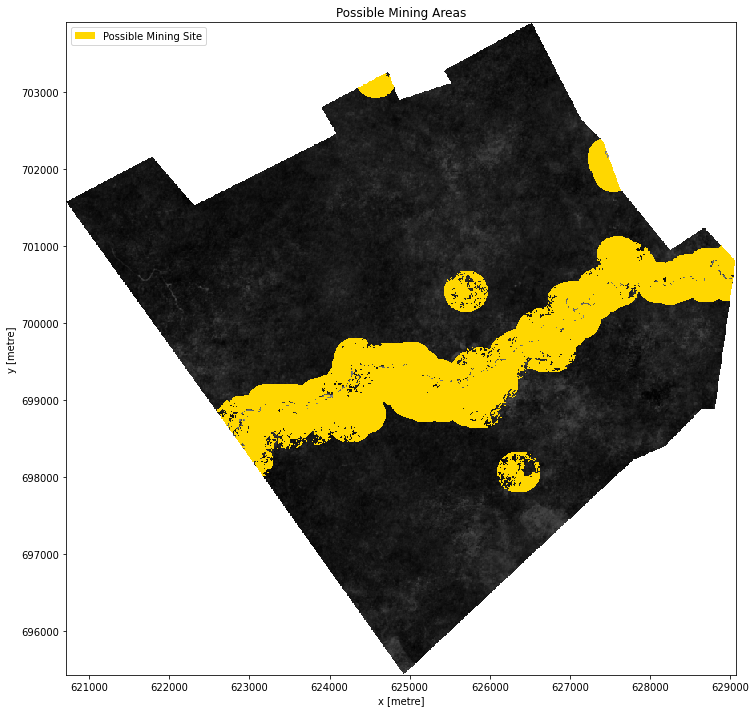

In [8]:
vegetation_loss_mining = plot_possible_mining(sentinel_2, veg_loss_all, wofs)

## Examine vegetation loss from possible mining each year

The final function compares the vegetation loss from possible mining to all vegetation loss each year, and builds a spatial plot showing the vegetation loss from possible mining each year.

<Figure size 864x864 with 0 Axes>

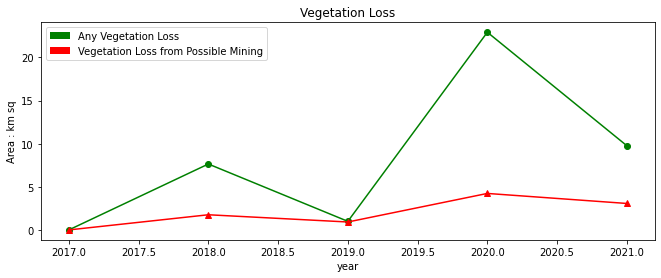

...................................................................


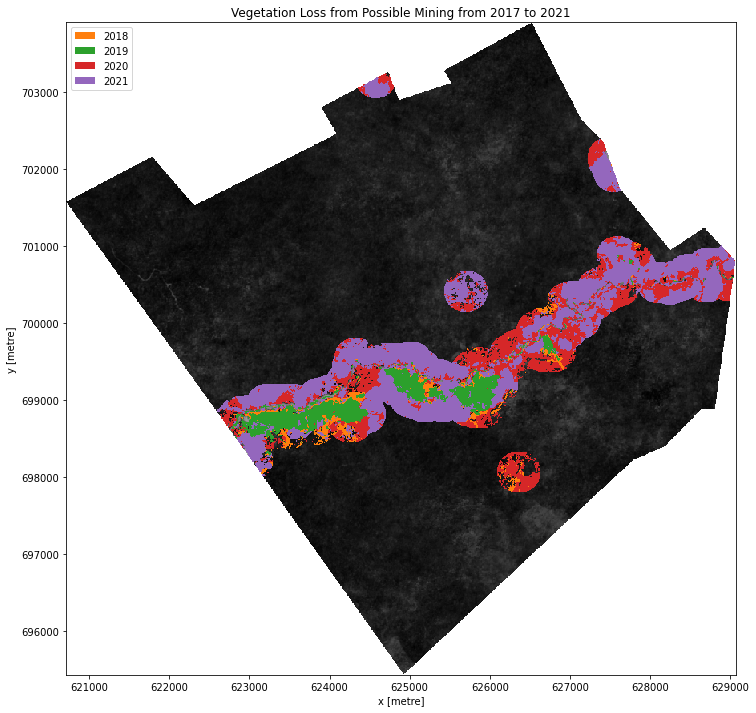

In [9]:
plot_vegetationloss_mining(sentinel_2, veg_loss_annual, vegetation_loss_mining)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** November 2020

**Compatible datacube version:** 

In [10]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)